In [ ]:
### analysis of task completion times per batch

In [36]:
import pandas as pd
import os
import seaborn as sns
import json

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from chatgpt_poc.csv import write_csv, read_csv
from datetime import datetime, timedelta
from IPython.display import display
from json import JSONDecodeError


In [2]:
# functions

def try_loads(resp):
    try:
        return json.loads(str(resp).replace('\'', '"').replace('\\n', ''))
    except JSONDecodeError as e:
        return f'JSONDecodeError - {e}'
    
def get_completion(resp):
    try:
        return try_loads(resp)["result"]
    except TypeError as e:
        return f'TypeError - {e}'

In [135]:
# data paths

"""
TESTS
    123ea82c-cada-11ed-8f06-00155d4b0375, 100, 3, 197s,
    87d905aa-cb8e-11ed-af46-00155d4b0375, 100, 3, 185s, 
    5e3f9faa-cb8f-11ed-8c8d-00155d4b0375, 1k, 3, 1851s, 
    873508aa-cb94-11ed-95c6-00155d4b0375, 10k, 4, 8296s,
    f232c332-cc51-11ed-82d2-00155d4b0375, 10k, 6, 10050s, 
    cef67440-c9ef-11ed-a5dc-00155d4b0375, 10k, 8, 1557
"""

# --- USER INPUT

batch_id = 'cef67440-c9ef-11ed-a5dc-00155d4b0375' # os.listdir('/home/nroshania/git/ChatGPT-POC/data/results/jobs/submitted')
concurrency = 6

home = '/home/nroshania/git/ChatGPT-POC/'
submitted_loc = f'{home}data/results/jobs/submitted/{batch_id}.csv'
completed_loc = f'{home}data/results/jobs/completed/{batch_id}.csv'
analysis_loc = f'{home}data/results/analysis/{batch_id}.csv'

# ----


# dataframes
df_submitted = pd.read_csv(submitted_loc, header=None)
df_completed = pd.read_csv(completed_loc, header=None)

# transformations
df_submitted.columns=['requested_ts', 'task_id']
df_completed.columns=['task_id', 'state', 'task_done_ts', 'result', 'retries']

df_submitted.loc[:, 'requested_ts'] = df_submitted.loc[:, 'requested_ts'].apply(lambda row: datetime.fromisoformat(row) if isinstance(row, str) else None)
df_completed.loc[:, 'task_done_ts'] = df_completed.loc[:, 'task_done_ts'].apply(lambda row: datetime.fromisoformat(row) if isinstance(row, str) else None)

res = df_submitted.join(df_completed.set_index('task_id'), on='task_id')

# parsing results json
jres = df_completed.result.apply(lambda row: try_loads(row))
text_completions = df_completed.result.apply(lambda row: get_completion(row))

res.loc[:, '_gptresponse'] = jres
res.loc[:, '_text_completions'] = text_completions
res.loc[:, 'started_ts'] = [datetime.fromisoformat(res['started_at']) if isinstance(res, dict) else None for res in jres]
res.loc[:, 'completed_ts'] = [datetime.fromisoformat(res['completed_at']) if isinstance(res, dict) else None for res in jres]

# calculats
res['task_duration_s'] = (res['completed_ts'] - res['started_ts']).apply(lambda row: round(sum([row.seconds, row.microseconds/1e6]), 2))
# res['task_started_ts'] = pd.Series(pd.array(res.task_duration_s, dtype=pd.Float64Dtype())).apply(lambda row: (df_completed.loc[:, 'task_done_ts'] - timedelta(seconds=row)) if isinstance(row, float) == True else None)
res_success = res.loc[res.state == 'SUCCESS', :]

# export aggregates
avg_tduration = res_success.task_duration_s.mean()
job_duration = (max(res_success.task_done_ts) - min(res_success.requested_ts)).seconds
# write aggregates to file

write_csv(
    file_loc=analysis_loc, 
    data=[
            [
                batch_id,
                min(res.requested_ts),
                max(res.task_done_ts),
                len(res),
                len(res_success),
                job_duration,
                round(avg_tduration, 3),
                round((len(res_success) / job_duration)*60, 2),
                list(zip(res.loc[:, 'state'], res.loc[:, 'task_duration_s'])),
                concurrency
                
            ]
    ],
    schema=[
        'job_id',
        'job_started',
        'job_completed',
        'total_tasks',
        'tasks_success',
        'job_duration_s',
        'avg_taskduration_s',
        'avg_tpm',
        'task_durations',
        'concurrency'
    ]
)
print(f'- data written to: {analysis_loc}')

# batch analyis concats
# read and display data in data/results/analysis
_batchanalysis = None

for tpath in os.listdir(f'{home}data/results/analysis'):
    if _batchanalysis is not None:
        _batchtesttest = pd.read_csv(f'{home}data/results/analysis/{tpath}')
        _batchanalysis = pd.concat([_batchanalysis, _batchtesttest])
    else:
        _batchanalysis = pd.read_csv(f'{home}data/results/analysis/{tpath}')


batch_analysis =_batchanalysis.copy()

# graphs
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

/tmp/ipykernel_8716/2203887713.py:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_submitted.loc[:, 'requested_ts'] = df_submitted.loc[:, 'requested_ts'].apply(lambda row: datetime.fromisoformat(row) if isinstance(row, str) else None)
/tmp/ipykernel_8716/2203887713.py:34: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_completed.loc[:, 'task_done_ts'] = df_completed.loc[:, 'task_done_ts'].apply(lambda row: datetime.fromisoformat(row) if isinstance(row, str) else None)


AttributeError: 'float' object has no attribute 'seconds'



    Summary of batches




,job_id,job_started,job_completed,total_tasks,tasks_success,job_duration_s,avg_taskduration_s,avg_tpm,task_durations,concurrency
0,f232c332-cc51-11ed-82d2-00155d4b0375,2023-03-27 03:46:24.628696,2023-03-27 06:33:55.277893,10000,10000,10050,5.972,59.70,"[('SUCCESS', 4.8), ('SUCCESS', 5.53), ('SUCCES...",6
0,873508aa-cb94-11ed-95c6-00155d4b0375,2023-03-26 05:10:30.263985,2023-03-26 07:28:46.453847,10000,10000,8296,5.805,72.32,"[('SUCCESS', nan), ('SUCCESS', 8.97), ('SUCCES...",4
0,87d905aa-cb8e-11ed-af46-00155d4b0375,2023-03-26 04:27:34.330995,2023-03-26 04:30:39.418069,100,100,185,4.870,32.43,"[('SUCCESS', 2.75), ('SUCCESS', 5.95), ('SUCCE...",3
0,123ea82c-cada-11ed-8f06-00155d4b0375,2023-03-25 06:55:47.615065,2023-03-25 06:59:05.392363,100,100,197,5.393,30.46,"[('SUCCESS', 9.04), ('SUCCESS', 8.99), ('SUCCE...",3
0,5e3f9faa-cb8f-11ed-8c8d-00155d4b0375,2023-03-26 04:33:34.038172,2023-03-26 05:04:25.565176,1000,1000,1851,5.528,32.41,"[('SUCCESS', nan), ('SUCCESS', nan), ('SUCCESS...",3



    
    job summary: f232c332-cc51-11ed-82d2-00155d4b0375
    
    started: 2023-03-27 03:46:24.628696
    completed: 2023-03-27 06:33:55.277893
    succeeded: 10000
    job duration: 10050s
    avg. task duration: 5.972s
    avg. rate: 59.7 tpm




,task_id,state,_gptresponse,_text_completions,requested_ts,task_done_ts,task_duration_s
0,1ef58757-02f3-4747-a9f1-d75334320cac,SUCCESS,"{'task_description': 'completion_task', 'resul...",[Suvrata Gupta is a recent graduate of Concord...,2023-03-27 03:46:24.628696,2023-03-27 03:46:29.680596,4.80
1,f353e8d4-a8d9-4385-a70a-63aab60aa27a,SUCCESS,"{'task_description': 'completion_task', 'resul...",[Jeet Prakash adalah Co-founder dari Pi To - J...,2023-03-27 03:46:24.809224,2023-03-27 03:46:30.417843,5.53
2,12c2af98-c956-4590-b3c5-e95a60eff2e5,SUCCESS,"{'task_description': 'completion_task', 'resul...","[Oi! Sou William Lopes, Sócio-Diretor de Geren...",2023-03-27 03:46:24.811100,2023-03-27 03:46:40.121206,15.23
3,8e3a0c46-b80b-4405-afae-386b80796a13,SUCCESS,"{'task_description': 'completion_task', 'resul...",[Jorge Martinez Sevilla es un profesional con ...,2023-03-27 03:46:24.811808,2023-03-27 03:46:35.940150,11.03
4,2f7d3470-fdcd-49c0-a737-d4a09a89145e,SUCCESS,"{'task_description': 'completion_task', 'resul...",[Siddharth Suresh is a global financial leader...,2023-03-27 03:46:24.812265,2023-03-27 03:46:30.334620,5.44
...,...,...,...,...,...,...,...
9995,d19a5954-f2b6-4ada-b8a0-03813437f55b,SUCCESS,"JSONDecodeError - Expecting ',' delimiter: lin...",TypeError - string indices must be integers,2023-03-27 03:46:27.727330,2023-03-27 06:33:45.037191,NaN
9996,1d507a82-b668-4c0f-919b-b1f5a2d67ade,SUCCESS,"{'task_description': 'completion_task', 'resul...",[Fernando Cesar Gomes de Souza é um profission...,2023-03-27 03:46:27.727598,2023-03-27 06:33:49.231274,5.49
9997,af76991b-9cbf-4a72-84bb-eba91970f9c4,SUCCESS,"{'task_description': 'completion_task', 'resul...",[Genevieve Billington is from the West Midland...,2023-03-27 03:46:27.727854,2023-03-27 06:33:46.867122,2.38
9998,2b89e61e-51ba-4b8e-8c04-19fc6ca966bd,SUCCESS,"JSONDecodeError - Expecting ',' delimiter: lin...",TypeError - string indices must be integers,2023-03-27 03:46:27.728110,2023-03-27 06:33:55.277893,NaN


,task_id
state,
SUCCESS,10000


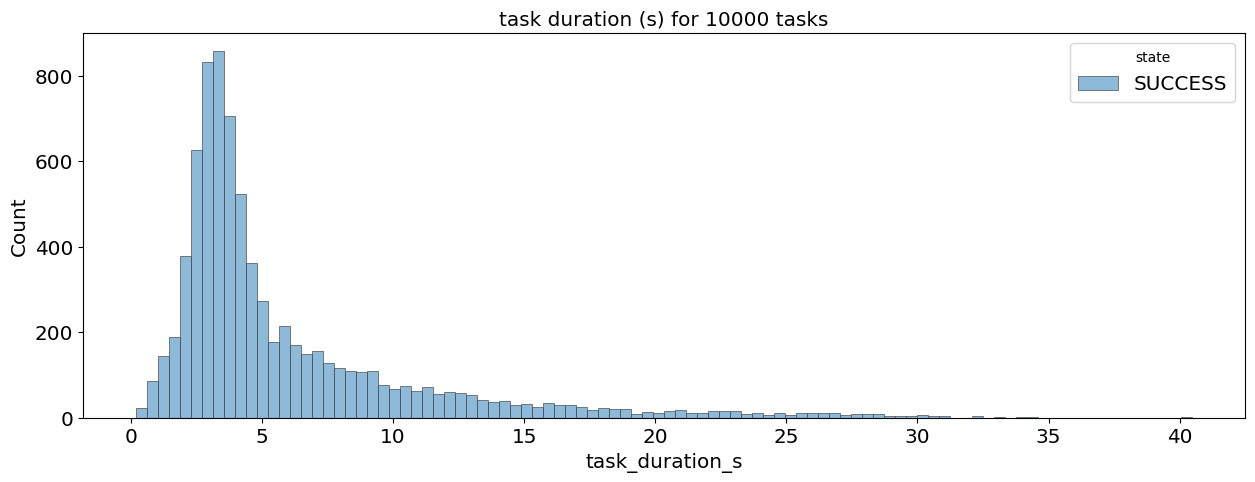

In [134]:
# metrics
job_duration = (max(res_success.task_done_ts) - min(res_success.requested_ts)).seconds
avg_tduration = res_success.task_duration_s.mean()


print(f"""

    Summary of batches

""")

display(batch_analysis)

print(f"""
    
    job summary: {batch_id}
    
    started: {min(res.requested_ts)}
    completed: {max(res.task_done_ts)}
    succeeded: {len(res_success)}
    job duration: {job_duration}s
    avg. task duration: {round(avg_tduration, 3)}s
    avg. rate: {round((len(res_success) / job_duration)*60, 2)} tpm

""")

display(res.loc[:, ['task_id', 'state','_gptresponse', '_text_completions', 'requested_ts', 'task_done_ts', 'task_duration_s']])
display(res.loc[:, ['state', 'task_id']].groupby('state').count())

# res.loc[res.state == 'SUCCESS', :].plot.scatter(x='requested_ts', y='task_duration_s') # task durations over time
# res.hist('task_duration_s') # task durations over time

fig, axs = plt.subplots(1, 1)
pylab.rcParams.update(params)

# ts = sns.scatterplot(
#     data=res,
#     x="requested_ts", y="task_duration_s",
#     hue="state", ax=axs[0]
# )

hst = sns.histplot(
    res,
    x="task_duration_s",
    hue="state",
    edgecolor=".3",
    linewidth=.5,
)

axs.set_title(f'task duration (s) for {len(res)} tasks')
plt.show()


In [58]:
timedelta(seconds=4)

datetime.timedelta(seconds=4)